# Carregamento dos Dados

In [2]:
import pandas as pd
df = pd.read_csv("PETR4.SA_maior.csv")

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6052,2024-02-06,41.450001,42.349998,41.270000,41.590000,41.590000,35474600.0
6053,2024-02-07,41.520000,42.200001,41.419998,42.200001,42.200001,30648100.0
6054,2024-02-08,42.299999,42.450001,41.860001,41.860001,41.860001,25589100.0
6055,2024-02-09,42.139999,42.330002,41.299999,41.299999,41.299999,30388000.0
6056,2024-02-14,41.099998,41.400002,40.860001,40.990002,40.990002,18315300.0


## E se removéssemos o período da pandemia?

In [3]:
df["Date"]

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
6052    2024-02-06
6053    2024-02-07
6054    2024-02-08
6055    2024-02-09
6056    2024-02-14
Name: Date, Length: 6057, dtype: object

In [4]:
from datetime import datetime as dt

df["Date"] = pd.to_datetime(df["Date"]) #converte para tipo datetime

df["Date"]

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
6052   2024-02-06
6053   2024-02-07
6054   2024-02-08
6055   2024-02-09
6056   2024-02-14
Name: Date, Length: 6057, dtype: datetime64[ns]

In [5]:
df = df[(df["Date"] < '2020-08-01')] #só vou trabalhar com o período de 2013 até junho de 2020

# Tem linha do dataframe com dados faltando?

In [6]:
df[df.isna().any(axis=1)] #verifica qual linha é

,Date,Open,High,Low,Close,Adj Close,Volume
1261,2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
len(df)

5180

In [8]:
df = df.dropna()

len(df)

5179

In [9]:
prices = df['Close']

# Visualização dos Dados

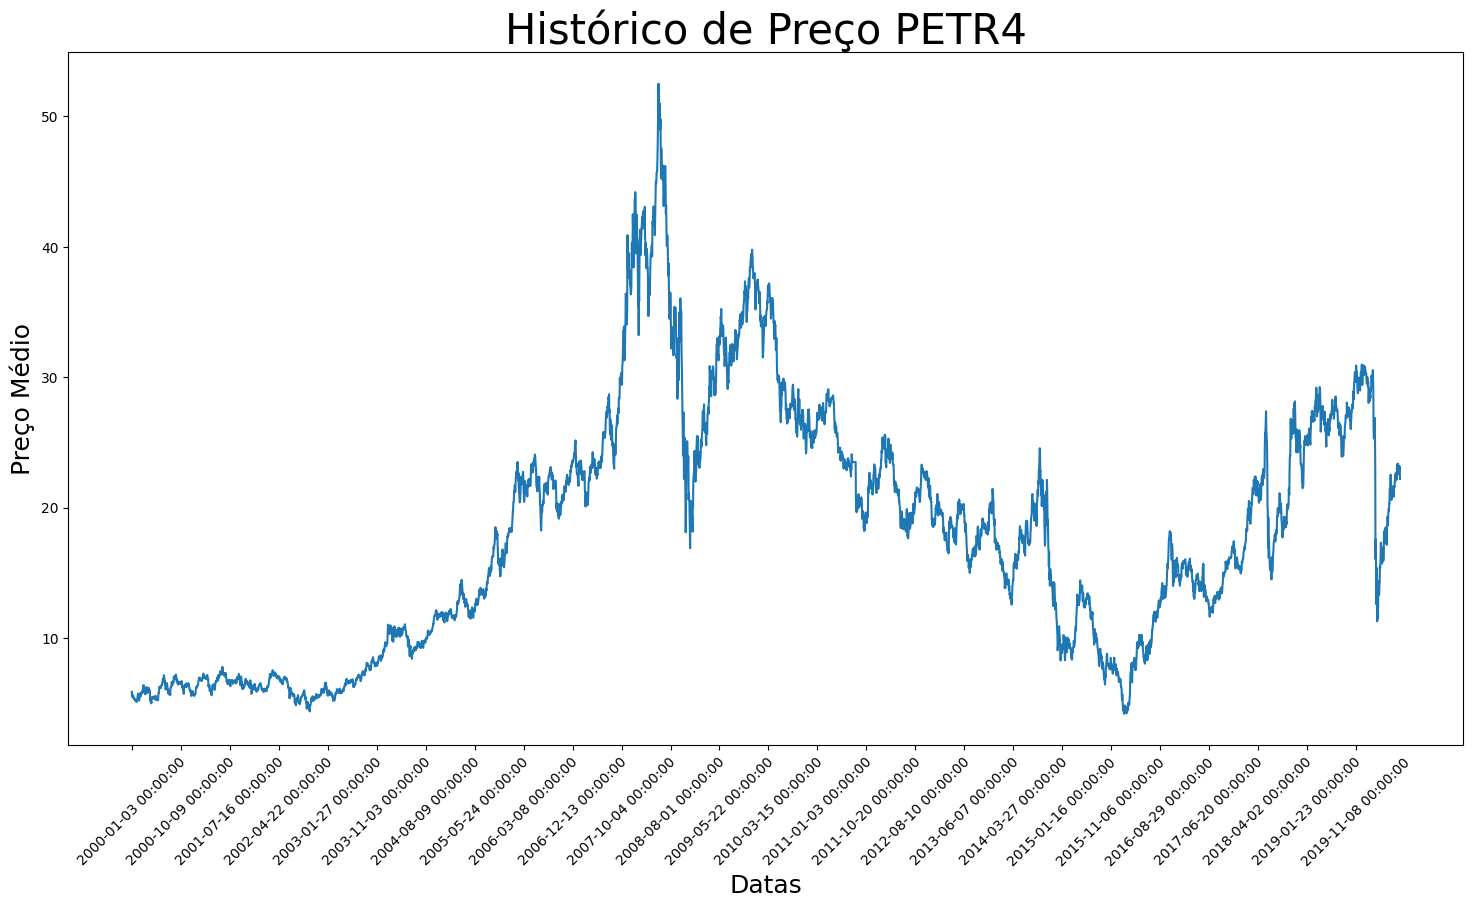

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.show()

In [11]:
days_time_step = 15

# Separação Teste e Treino

In [12]:
import numpy as np
training_size = int(len(prices) * 0.90)
test_size = len(prices) - training_size

train_data, input_data = np.array(prices[0:training_size]), np.array(prices[training_size - days_time_step:])
test_data = np.array(prices[training_size:])

train_data.shape, test_data.shape

((4661,), (518,))

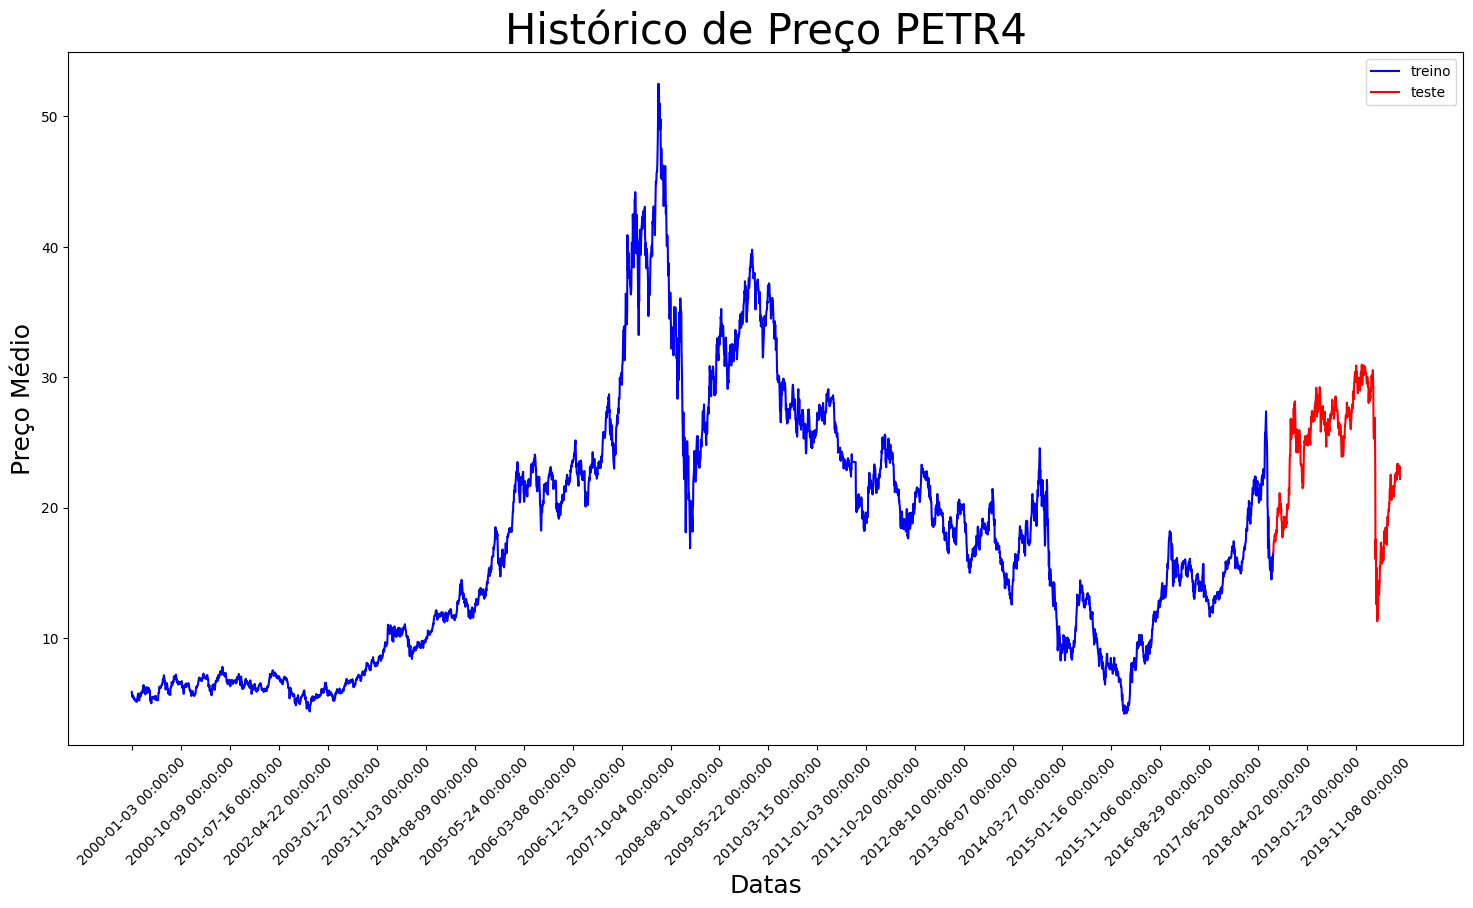

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'].loc[0:train_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(df['Close'].loc[train_data.shape[0]:], color = 'red', label = 'teste')
plt.xticks(range(0,df.shape[0],200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

# Normalização dos Dados

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data_norm = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_norm = scaler.transform(np.array(input_data).reshape(-1,1))
val_data_norm = scaler.transform(np.array(test_data).reshape(-1,1))

test_data_norm.shape

(533, 1)

# Pré-processamento (Gerando X e y)

In [15]:
#treino
X_train, y_train = [], []
for i in range(days_time_step, len(train_data)):
    X_train.append(train_data_norm[i-days_time_step:i])
    y_train.append(train_data_norm[i])
    
#teste
X_test = []
for i in range(days_time_step, days_time_step + len(test_data)):
    X_test.append(test_data_norm[i-days_time_step:i])
    
#val
X_val, y_val = [], []
for i in range(days_time_step, len(test_data)):
    X_val.append(val_data_norm[i-days_time_step:i])
    y_val.append(val_data_norm[i])

#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test.shape

(518, 15, 1)

# Treinamento de Rede Neural

In [16]:
import tensorflow as tf

tf.__version__

'2.15.0'

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30

146/146 [==============================] - 18s 48ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 2/30
146/146 [==============================] - 4s 27ms/step - loss: 4.9170e-04 - val_loss: 0.0011
Epoch 3/30
146/146 [==============================] - 4s 26ms/step - loss: 4.7293e-04 - val_loss: 0.0010
Epoch 4/30
146/146 [==============================] - 4s 25ms/step - loss: 4.0644e-04 - val_loss: 7.5226e-04
Epoch 5/30
146/146 [==============================] - 4s 25ms/step - loss: 3.8150e-04 - val_loss: 9.5282e-04
Epoch 6/30
146/146 [==============================] - 4s 25ms/step - loss: 3.7611e-04 - val_loss: 9.7876e-04
Epoch 7/30
146/146 [==============================] - 4s 28ms/step - loss: 3.1882e-04 - val_loss: 5.3278e-04
Epoch 8/30
146/146 [==============================] - 4s 26ms/step - loss: 2.7785e-04 - val_loss: 4.6935e-04
Epoch 9/30
146/146 [==============================] - 4s 27ms/step - loss: 2.6726e-04 - val_loss: 4.2443e-04
Epoch 10/30
146/146 [============

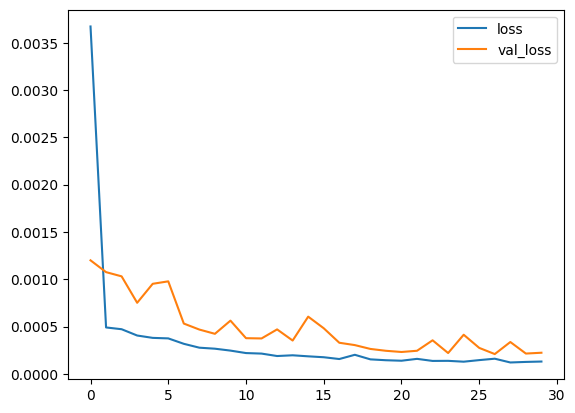

In [19]:
import matplotlib.pyplot as plt

plt.plot(h.history["loss"], label='loss')
plt.plot(h.history["val_loss"], label='val_loss')
plt.legend()

# Avaliação de Resultados

In [20]:
#predição de valores pela rede
predict = model.predict(X_test)

#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict)
real = test_data

predict.shape

17/17 [==============================] - 3s 14ms/step


(518, 1)

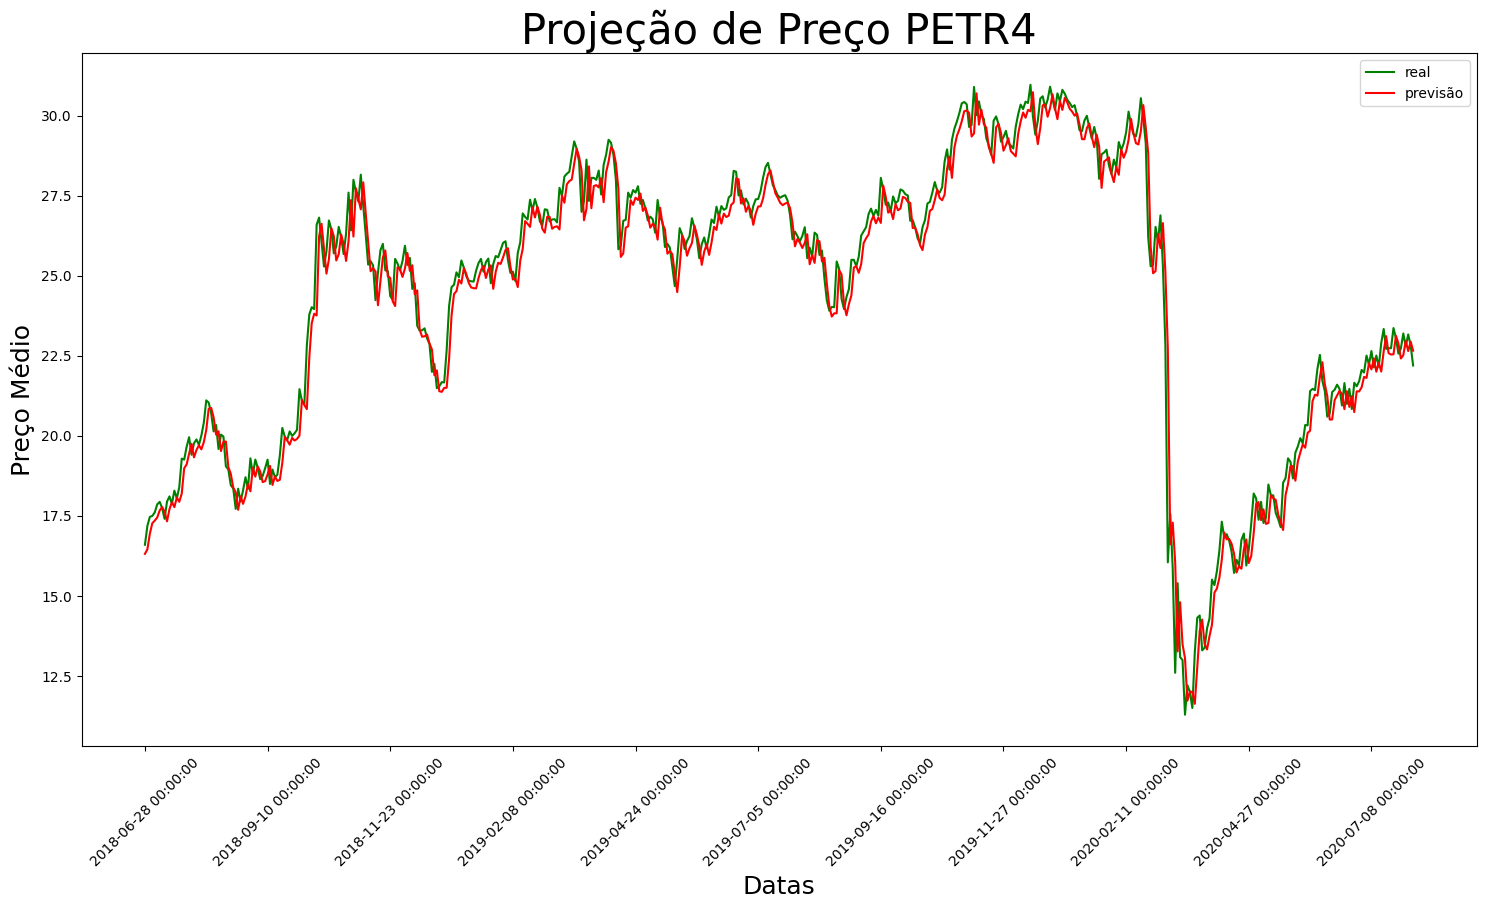

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(predict, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [22]:
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(real, predict)

0.5134149695979697

# Referências

* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/#:~:text=LSTMs%20are%20widely%20used%20for,the%20information%20that%20is%20not.
* https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/
* https://medium.com/alexandre-george-lustosa/previs%C3%A3o-de-pre%C3%A7o-petr4-com-python-lstm-f93722be59e0
* https://finance.yahoo.com/quote/PETR4.SA/history?period1=1356998400&period2=1640995200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
* http://revistagt.fpl.edu.br/get/article/view/1930/1230